In [1]:
# Install required packages here if needed (remove '#')
#!pip3 install pandas
#!pip3 install pandas_datareader
#!pip3 install datetime

# !pip3 install PyPortfolioOpt

In [35]:
#imports for Stock portfolio:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

#imports for optimizing stock portfolio
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Predicting stock portfolio by using multivariate Normal distribution with Cholesky decomposition


## get the Means and Covs of a 1 stock or multiple

In [57]:
def read_Mean_Cov(stock_symbol, start_date, end_date):
    """Import price data from Yahoo Finance"""
    try:
        stock_data = pdr.get_data_yahoo(stock_symbol, start_date, end_date)
    except:
        return None

    prices = stock_data.loc[:, "Adj Close"] # adjusted for stock splits and dividends
    prices = prices.fillna(method="ffill")
    returns = prices.pct_change()
    meanReturns = returns.mean()
    covReturns = returns.cov()
    return meanReturns, covReturns


stocks = ["TSLA", "F" ]
end_date1 = dt.datetime.now()
start_date1 = end_date1 - dt.timedelta(days=3650)


mean, cov = read_Mean_Cov(stocks, start_date1, end_date1)
print(mean)
cov

mean2, cov2 = read_Mean_Cov(['^GSPC'], start_date1, end_date1)
print(mean2)



Symbols
TSLA    0.002561
F       0.000458
dtype: float64


Symbols,TSLA,F
Symbols,,
TSLA,0.001264,0.000219
F,0.000219,0.000443


Symbols
^GSPC    0.00044
dtype: float64


Symbols
TSLA    0.002560
F       0.000457
dtype: float64
[0.5, 0.5]


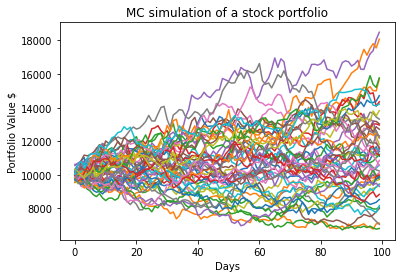

In [65]:
#Weight can be random or chosen
def monto_carlo_Sim(stocks, start_date, end_date, sims, time, weights_given):
    mean, cov = read_Mean_Cov(stocks, start_date, end_date)
    print(mean)
    weights = weights_given
    if weights == []:
        weights = np.random.random(len(mean))
        weights /= np.sum(weights)
        weights
    elif np.sum(weights) != 1:
        print('Weight is not summed up to 1')
        return None
    print(weights)

    meanM = np.full(shape=(time,len(weights)), fill_value=mean)
    meanM = meanM.T

    portfolio = np.full(shape=(time, sims), fill_value=0.0)
    initialPortfolio = 10000
    
    for m in range(sims):
        #MC loops
        normal = np.random.normal(size=(time,len(weights)))
        lower = np.linalg.cholesky(cov)
        dailyReturns = meanM + np.inner(lower,normal)
        portfolio[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio


    plt.plot(portfolio)
    plt.ylabel('Portfolio Value $')
    plt.xlabel('Days')
    plt.title('MC simulation of a stock portfolio')
    plt.show();    
    
    

stocks = ["TSLA", "F" ]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=3650)
sims = 50
time = 100
# monto_carlo_Sim(stocks, start_date, end_date, sims, time, [])

monto_carlo_Sim(stocks, start_date, end_date, sims, time, [0.5,0.5])


# optimizing an stock portfolio by using PyPortfolio Opt

In [32]:
def read_prices(stocks, start_date, end_date): 
    try:
        stock_data = pdr.get_data_yahoo(stocks, start_date, end_date)
    except:
        return none
    prices = stock_data.loc[:, "Adj Close"] # adjusted for stock splits and dividends
    prices = prices.fillna(method="ffill")
    return prices

def Optimize_Portfolio_Weights(stocks, start_date, end_date):
    prices = read_prices(stocks, start_date, end_date)
    
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)

    # Optimize for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    # ef.save_weights_to_file("weights.csv")  # saves to file
    print(ef.portfolio_performance(verbose=True))
    return cleaned_weights
    

stocks = ["TSLA", "F", "AAPL", "GOOG", "MSFT", "AMZN", "META", "NVDA"]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=700)

Optimize_Portfolio_Weights(stocks, start_date, end_date)





Expected annual return: 28.3%
Annual volatility: 41.8%
Sharpe Ratio: 0.63
(0.2831864706311629, 0.41758289854127756, 0.6302616116477463)


OrderedDict([('TSLA', 0.28359),
             ('F', 0.71641),
             ('AAPL', 0.0),
             ('GOOG', 0.0),
             ('MSFT', 0.0),
             ('AMZN', 0.0),
             ('META', 0.0),
             ('NVDA', 0.0)])

In [40]:
def Optimize_Given_Funds(stocks, start_date, end_date, funds):
    weights = Optimize_Portfolio_Weights(stocks, start_date, end_date)
    print()
    print(weights)
    prices = read_prices(stocks, start_date, end_date)
    latest_prices = get_latest_prices(prices)

    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
    allocation, leftover = da.greedy_portfolio()
    print("\nDiscrete allocation:", allocation)
    print("Funds remaining: ${:.2f}".format(leftover))
    
stocks = ["TSLA", "F", "AAPL", "GOOG", "MSFT", "AMZN", "META", "NVDA"]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=700)
funds = 100000
Optimize_Given_Funds(stocks, start_date, end_date, funds)

Expected annual return: 28.2%
Annual volatility: 41.8%
Sharpe Ratio: 0.63
(0.28236762525039694, 0.41756880295751747, 0.6283219038206971)
OrderedDict([('TSLA', 0.28699), ('F', 0.71301), ('AAPL', 0.0), ('GOOG', 0.0), ('MSFT', 0.0), ('AMZN', 0.0), ('META', 0.0), ('NVDA', 0.0)])

Discrete allocation: {'F': 582, 'TSLA': 12}
Funds remaining: $126.01
